In [1]:
# Install Altair if needed
# !pip install altair

In [2]:
#import libraries
import os
import sys
import re

import numpy as np
import csv
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Visual Analysis

The first step in our EDA was a visual inspection of the images we collected. Several images we collected were either too dark, too light, blurry, or in some cases were not pictures of a throat. We excluded these images from the csv file which contained all the data we intended to include in our analysis.

In [3]:
#importing dataset
df = pd.read_csv('W251 ML Covid Image Analysis_March 5, 2022_23.06.csv', header=0, skiprows=[1,2])

## Identifying Usable Features
After removing the obvious data in the form of unusable images, we check the column names to identify the features we need. We realized that we didn't need most of the fields from the Qualtrics survey. We did however need the ResponseID to correlate the results to the images. 

In [4]:
# checking the column names
df_cols = list(df.columns)
df_cols

['StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'd_age_1',
 'd_gender',
 'd_vacc_status_1',
 'd_race',
 'd_race_6_TEXT',
 'v_temp_unit',
 'v_temp_c_1',
 'v_temp_f_1',
 'v_cough',
 's_antipyretic',
 's_odynophagia',
 's_odynophagia_days',
 's_dysphagia',
 's_dysphagia_days',
 't_rtpcr',
 't_rtpcr_date',
 't_ag',
 't_ag_date',
 't_med',
 'd_dx',
 'd_img1_Id',
 'd_img1_Name',
 'd_img1_Size',
 'd_img1_Type',
 'd_img2_Id',
 'd_img2_Name',
 'd_img2_Size',
 'd_img2_Type',
 'd_img3_Id',
 'd_img3_Name',
 'd_img3_Size',
 'd_img3_Type',
 'source']

### The below script removed the unneeded fields and moved the label column to the front for easy visualization. 

In [4]:
# Fields we will use for analysis
req_columns = ['d_dx','ResponseId']

d_cols = [c for c in df_cols if c[1] == '_' and c != 'd_dx'] 
req_columns.extend(d_cols)
ren_columns = [c if not c.endswith('_1') else c[:-2] for c in req_columns ]

In [5]:
df = df[req_columns]
print(f"DataFrame object now has {df.shape[0]} rows and {df.shape[1]} columns")
df.columns = ren_columns
df.describe()

DataFrame object now has 142 rows and 33 columns


,d_age,d_vacc_status,v_temp_c,v_temp_f,s_odynophagia_days,s_dysphagia_days,d_img1_Size,d_img2_Size,d_img3_Size
count,140.000000,36.000000,135.000000,5.000000,11.000000,10.000000,1.380000e+02,3.000000e+01,1.800000e+01
mean,38.185714,2.166667,37.112593,98.460000,8.090909,8.800000,5.422573e+05,1.413368e+06,1.466108e+06
std,19.034080,0.941124,0.756211,0.134164,4.846742,5.006662,1.528889e+06,7.052928e+05,8.545069e+05
min,7.000000,0.000000,35.700000,98.400000,3.000000,2.000000,1.170200e+04,1.398000e+04,6.112500e+04
25%,23.000000,2.000000,36.600000,98.400000,5.000000,5.250000,2.043500e+04,9.810100e+05,9.584202e+05
50%,36.000000,2.000000,37.000000,98.400000,6.000000,8.500000,3.013150e+04,1.379062e+06,1.368224e+06
75%,50.250000,3.000000,37.500000,98.400000,12.000000,13.000000,8.084400e+05,1.650375e+06,1.615349e+06
max,91.000000,3.000000,40.200000,98.700000,16.000000,16.000000,1.618552e+07,3.548658e+06,3.571281e+06


## Handling Missing Data
Now that we have the feature list we plan to use we need to identify if there are any incorrect or missing values. Incorrect or missing values in the dataset would either cause errors or cause our final outputs to be incorrect. As shown below, after importing our data, we did have missing or NaN data that needed to be addressed. Fortunately after reviewing the columns, we determined that we didn't need most of the columns and the columns we used all contained usable data.

### The function below prints out a detailed Exploratory Data Analysis of the dataset that will review incorrect and missing data.

In [6]:
def eda(df,col_names=None, row_width=60 ):
    columns = list(df.columns) if col_names is None else col_names
    print('='*row_width)
    print('df')
    print(f"{len(columns)} Reported \t{df.shape[1]} Columns\t{df.shape[0]} Rows" )
    d_res = pd.DataFrame()
    for i,col in enumerate(columns):
        res = {}
        print('-'*row_width)
        dtype_name = df[col].dtype 
        res['dtype'] = dtype_name
        res['n'] = df[col].count()
        res['NaN'] = df[col].isnull().sum()
        res['unique'] = len(df[col].unique())
        print(f"  {col}")
        d_col = pd.DataFrame([res],index=[col])
        
        print(d_col.to_string(index=False))
        if res['unique'] < 15 or dtype_name == 'object':
            d_col_counts = df[col].value_counts(dropna=False)
            d_col_counts.name = 'Count'
            d_col_freq = df[col].value_counts(dropna=False, normalize=True)
            d_col_freq.name = 'Freq'
            df_col = pd.concat([d_col_counts,d_col_freq],axis=1)
            df_col = df_col.transpose()
            df_col.columns = [str(c)[:8] + ".." if len(str(c)) > 8 else str(c)[:8] for c in df_col.columns]
            if res['unique'] > 10:
                df_col_1 = df_col.iloc[:,:5]
                df_col_2 = df_col.iloc[:,-5:] 
                df_col = df_col_1.join(df_col_2, lsuffix='_1',rsuffix='_2')
            print(df_col.to_string())
            res['mode'] = df[col].dropna().mode()
        if dtype_name == "float":
            res['min'] = df[col].dropna().min()
            res['median'] = df[col].dropna().median()
            res['mode'] = df[col].dropna().mode()
            res['max'] = df[col].dropna().max()
        d_col = pd.DataFrame([res],index = [col])
        d_res = pd.concat([d_res,d_col])

    print('='*row_width)
    return d_res

### Run the eda script

In [7]:
eda(df)

df
33 Reported 	33 Columns	142 Rows
------------------------------------------------------------
  d_dx
 dtype   n  NaN  unique
object 136    6       6
          Normal  Bacteria..      Covid     Viral       nan     Other
Count  53.000000    49.00000  24.000000  7.000000  6.000000  3.000000
Freq    0.373239     0.34507   0.169014  0.049296  0.042254  0.021127
------------------------------------------------------------
  ResponseId
 dtype   n  NaN  unique
object 142    0     142
       R_2b30KZ..  R_3KIM2A..  R_a3l0EO..  R_3lRoIs..  R_x431CM..  R_2CprkD..  R_2xDgJx..  R_2Se2TY..  R_2R93EL..  R_2q1Pvw..
Count    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
Freq     0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042
------------------------------------------------------------
  d_age
  dtype   n  NaN  unique
float64 140    2      58
-------------------

              nan  IMG_7698..  16461774..  16461774..  20220301..  IMG_7670..  IMG_7667..  IMG_7658..  IMG_8141..  16461777..
Count  124.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
Freq     0.873239    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042    0.007042
------------------------------------------------------------
  d_img3_Size
  dtype  n  NaN  unique
float64 18  124      19
------------------------------------------------------------
  d_img3_Type
 dtype  n  NaN  unique
object 18  124       3
              nan  image/he..  image/jp..
Count  124.000000   12.000000    6.000000
Freq     0.873239    0.084507    0.042254


,dtype,n,NaN,unique,mode,min,median,max
d_dx,object,136,6,6,"0 Normal Name: d_dx, dtype: object",NaN,NaN,NaN
ResponseId,object,142,0,142,0 R_0dE4arEYyn9VJOV 1 R_10vi04lh64FG...,NaN,NaN,NaN
d_age,float64,140,2,58,"0 36.0 Name: d_age, dtype: float64",7.0,36.0,91.0
d_gender,object,137,5,3,"0 Male Name: d_gender, dtype: object",NaN,NaN,NaN
d_vacc_status,float64,36,106,5,"0 3.0 Name: d_vacc_status, dtype: float64",0.0,2.0,3.0
d_race,object,138,4,5,"0 Other Name: d_race, dtype: object",NaN,NaN,NaN
d_race_6_TEXT,object,8,134,3,"0 Hispanic Name: d_race_6_TEXT, dtype: object",NaN,NaN,NaN
v_temp_unit,object,140,2,3,"0 Celsius Name: v_temp_unit, dtype: object",NaN,NaN,NaN
v_temp_c,float64,135,7,32,"0 37.0 Name: v_temp_c, dtype: float64",35.7,37.0,40.2
v_temp_f,float64,5,137,3,"0 98.4 Name: v_temp_f, dtype: float64",98.4,98.4,98.7


### Based on the EDA we observe the following: Data Structure:

- <B>Prescription</B> d_dx has 6 Non-Numeric values. Some of the test data was incorrectl included into the download and these values should be dropped.
- <B>Age, Gender, Race, Cough, Antipyertic (fever reducing medicines), Odynophagia (Painful Swallowing), Dysphagia (Difficulty Swallowing), RTPCR Test, Antigen (AG Test)</B> each have less than 6 records with invalid values. If all of these records overlap if d_dx value, then we can safely drop the values.
- <b>Image 1 ID</b> has 4 fields without value, hence excluding test surveys all records appear to have at least one image.
There are 30 records with 2 images and only 18 with 3 images for the same patient.


### Drop the records with NaN and check again.

In [8]:
dropNAColumns = ['d_age', 'd_dx']

df_clean = df.dropna(subset=dropNAColumns)
df_clean.reset_index(drop=True, inplace=True)
# Vaccination record is assumed to be non-vaccinated if user doesn't confirm
df_clean.loc[:,'d_vacc_status'] = df_clean['d_vacc_status'].fillna(0)

/tmp/ipykernel_19960/3417708889.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:,'d_vacc_status'] = df_clean['d_vacc_status'].fillna(0)


## Identify any remaining missing values and drop them
There was only one missing value which was located under gender.

In [9]:
# Checking the missing values
df_clean.isnull().sum()

d_dx                    0
ResponseId              0
d_age                   0
d_gender                1
d_vacc_status           0
d_race                  0
d_race_6_TEXT         127
v_temp_unit             0
v_temp_c                4
v_temp_f              131
v_cough                 0
s_antipyretic           0
s_odynophagia           0
s_odynophagia_days    125
s_dysphagia             0
s_dysphagia_days      126
t_rtpcr                 0
t_rtpcr_date          121
t_ag                    0
t_ag_date             116
t_med                 112
d_img1_Id               0
d_img1_Name             0
d_img1_Size             0
d_img1_Type             0
d_img2_Id             105
d_img2_Name           105
d_img2_Size           105
d_img2_Type           105
d_img3_Id             117
d_img3_Name           117
d_img3_Size           117
d_img3_Type           117
dtype: int64

In [10]:
# Dropping the records with age missing in data dataframe.
df_clean = df_clean[~df_clean.d_gender.isnull()].copy()

# Checking the missing values in the dataset.
df_clean.isnull().sum()

d_dx                    0
ResponseId              0
d_age                   0
d_gender                0
d_vacc_status           0
d_race                  0
d_race_6_TEXT         126
v_temp_unit             0
v_temp_c                4
v_temp_f              130
v_cough                 0
s_antipyretic           0
s_odynophagia           0
s_odynophagia_days    124
s_dysphagia             0
s_dysphagia_days      125
t_rtpcr                 0
t_rtpcr_date          120
t_ag                    0
t_ag_date             115
t_med                 111
d_img1_Id               0
d_img1_Name             0
d_img1_Size             0
d_img1_Type             0
d_img2_Id             104
d_img2_Name           104
d_img2_Size           104
d_img2_Type           104
d_img3_Id             116
d_img3_Name           116
d_img3_Size           116
d_img3_Type           116
dtype: int64

## Additional Data Cleaning
After identifying and removing bad data, addional steps are required to prepare data to be used for training our DNN algorithms.

### Rename race to identified text if the other value is specified.

In [11]:
df_clean.loc[(df_clean['d_race'] == "Other") & (df_clean['d_race_6_TEXT'].notna()), 'd_race'] = df_clean['d_race_6_TEXT']

### Convert all the temperatures to Fahrenherit

In [12]:
df_clean['v_temperature'] = np.where(df_clean['v_temp_unit'] == 'Celsius', round(df_clean['v_temp_c']*1.8 +32 ,1), df_clean['v_temp_f'])

### Convert categorical values to numerical values for the following
- <B>Gender:</B> Male to 0 and Female to 1
- <B>s_antipyretic status:</B> No to 0 and Yes to 1
- <B>s_odynophagia:</B> None to 0, Low to 1, Medium to 2, and High to 3
- <B>s_dysphagia:</B> None to 0, Low to 1, Medium to 2, and High to 3

In [13]:
df_clean = df_clean.replace({'d_gender':{'Male':0,'Female':1},
                 's_antipyretic': {"No":0,"Yes":1},
                 's_odynophagia': {'None':0, 'Low':1, 'Medium':2,'High':3},
                 's_dysphagia' : {'None':0, 'Low':1, 'Medium':2,'High':3}})

### Create one hot encoding for t_med

In [14]:
df_clean['t_med2'] = [str.split(
    re.sub(r'^\s+|\s+$',  '',
        re.sub(r',[,\s]', ',',
               str(x).lower().replace(' and ',',').replace('antibiotics','antibiotic')
               )),
    ',')
  for x in df_clean['t_med']]
df_med = df_clean['t_med2'].explode().str.get_dummies().sum(level=0).add_prefix('t_med_')
df_clean = df_clean.join(df_med)
df_clean.head()


/tmp/ipykernel_19960/3794444175.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_med = df_clean['t_med2'].explode().str.get_dummies().sum(level=0).add_prefix('t_med_')


,d_dx,ResponseId,d_age,d_gender,d_vacc_status,d_race,d_race_6_TEXT,v_temp_unit,v_temp_c,v_temp_f,...,t_med_iantiviral,t_med_insulin,t_med_insuline,t_med_losartan,t_med_nan,t_med_none,t_med_omeprazole,t_med_retroviral,t_med_telmisartan,t_med_troferit
0,Normal,R_31pB9W7t53CMnvl,50.0,0,3.0,Asian,NaN,Fahrenheit,NaN,98.4,...,0,0,0,0,1,0,0,0,0,0
1,Normal,R_vpLYwUqW7mLyttn,72.0,1,3.0,Asian,NaN,Fahrenheit,NaN,98.4,...,0,0,0,0,1,0,0,0,0,0
2,Normal,R_1P7Ds55gFHWBsAe,45.0,0,3.0,Black or African American,NaN,Fahrenheit,NaN,98.7,...,0,0,0,0,1,0,0,0,0,0
3,Other,R_32SoCpPkA0chwa7,53.0,0,1.0,Other,NaN,Celsius,38.4,NaN,...,0,0,0,0,0,1,0,0,0,0
4,Normal,R_10vi04lh64FGSvp,23.0,0,3.0,White,NaN,Celsius,36.6,NaN,...,0,0,0,0,1,0,0,0,0,0


## Separate columns to prepare for final EDA script run

In [15]:
df_clean_cols = df_clean.columns
req_cols = ['d_dx','ResponseId','d_age','d_gender','d_vacc_status','d_race','v_temperature', 'v_cough']
symptom_cols = [c for c in df_clean_cols if c.startswith('s_') and not 'day' in c] 
treat_cols = [c for c in df_clean_cols if c.startswith('t_') and not 'date' in c and not 'med' in c] 
med_cols = [c for c in df_clean_cols if c.startswith('t_med_')]
final_cols = req_cols + symptom_cols + treat_cols + med_cols

In [16]:
df_final = df_clean[final_cols]
eda(df_final, req_cols+symptom_cols+treat_cols)

df
13 Reported 	50 Columns	134 Rows
------------------------------------------------------------
  d_dx
 dtype   n  NaN  unique
object 134    0       5
         Normal  Bacteria..      Covid     Viral     Other
Count  52.00000   48.000000  24.000000  7.000000  3.000000
Freq    0.38806    0.358209   0.179104  0.052239  0.022388
------------------------------------------------------------
  ResponseId
 dtype   n  NaN  unique
object 134    0     134
       R_31pB9W..  R_3lRoIs..  R_1dfXGn..  R_3LiN1U..  R_12JQhe..  R_3GANCS..  R_3Dvvwc..  R_3Mrigf..  R_1JLUvn..  R_2q1Pvw..
Count    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
Freq     0.007463    0.007463    0.007463    0.007463    0.007463    0.007463    0.007463    0.007463    0.007463    0.007463
------------------------------------------------------------
  d_age
  dtype   n  NaN  unique
float64 134    0      54
----------------------------------------------------

,dtype,n,NaN,unique,mode,min,median,max
d_dx,object,134,0,5,"0 Normal Name: d_dx, dtype: object",NaN,NaN,NaN
ResponseId,object,134,0,134,0 R_0dE4arEYyn9VJOV 1 R_10vi04lh64FG...,NaN,NaN,NaN
d_age,float64,134,0,54,"0 36.0 Name: d_age, dtype: float64",13.0,36.0,91.0
d_gender,int64,134,0,2,"0 0 1 1 Name: d_gender, dtype: int64",NaN,NaN,NaN
d_vacc_status,float64,134,0,4,"0 0.0 Name: d_vacc_status, dtype: float64",0.0,0.0,3.0
d_race,object,134,0,6,"0 Other Name: d_race, dtype: object",NaN,NaN,NaN
v_temperature,float64,134,0,32,"0 98.6 Name: v_temperature, dtype: float64",96.3,98.4,104.4
v_cough,object,134,0,3,"0 None Name: v_cough, dtype: object",NaN,NaN,NaN
s_antipyretic,int64,134,0,2,"0 0 Name: s_antipyretic, dtype: int64",NaN,NaN,NaN
s_odynophagia,int64,134,0,4,"0 0 Name: s_odynophagia, dtype: int64",NaN,NaN,NaN


## Multivariate Analysis
Run a correlation matrix to identify highly correlated features

                          d_age      d_gender  d_vacc_status  v_temperature  \
d_age                  1.000000 -1.242792e-01       0.201026      -0.114392   
d_gender              -0.124279  1.000000e+00       0.028296       0.015910   
d_vacc_status          0.201026  2.829559e-02       1.000000      -0.296904   
v_temperature         -0.114392  1.591005e-02      -0.296904       1.000000   
s_antipyretic          0.234846 -7.547224e-02      -0.178530       0.396907   
s_odynophagia         -0.023780  7.061267e-02      -0.303534       0.639657   
s_dysphagia           -0.034719  1.837450e-02      -0.292280       0.613156   
t_med_acetilcistein    0.139549 -8.671100e-02       0.036803      -0.082346   
t_med_acetoaminophen  -0.069995  8.671100e-02       0.118997      -0.158842   
t_med_advil            0.012000 -8.671100e-02       0.201190      -0.024975   
t_med_alprazolam       0.189657  8.671100e-02       0.118997      -0.069597   
t_med_amlopine         0.189657  8.671100e-02       

<AxesSubplot:>

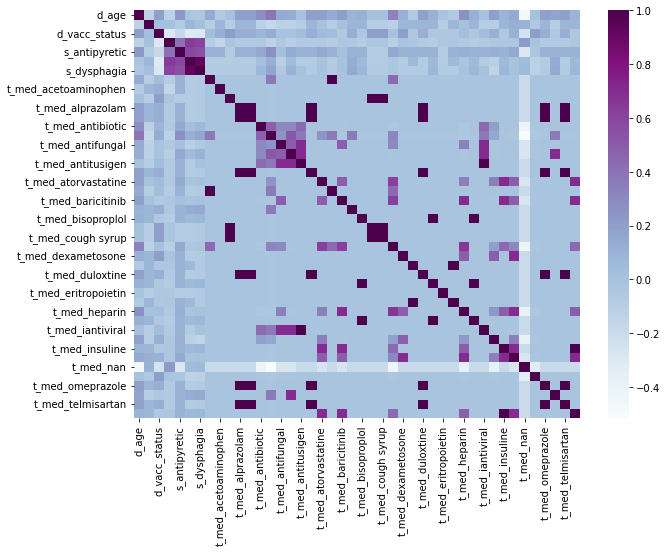

In [17]:
#finding correlation between the features
corr_var=df_final.corr()
print(corr_var)
plt.figure(figsize=(10,7.5))
sns.heatmap(corr_var, annot=False, cmap='BuPu')

## Altair Dynamic Correlation Matrix
With this chart we can hover over the intersection of features. This will allow us to quickly identify highly correlated features.

In [20]:
cor_data = (df_final
              .corr().stack()
              .reset_index()
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format)
cor_data.head(10)

,variable,variable2,correlation,correlation_label
0,d_age,d_age,1.000000,1.00
1,d_age,d_gender,-0.124279,-0.12
2,d_age,d_vacc_status,0.201026,0.20
3,d_age,v_temperature,-0.114392,-0.11
4,d_age,s_antipyretic,0.234846,0.23
5,d_age,s_odynophagia,-0.023780,-0.02
6,d_age,s_dysphagia,-0.034719,-0.03
7,d_age,t_med_acetilcistein,0.139549,0.14
8,d_age,t_med_acetoaminophen,-0.069995,-0.07
9,d_age,t_med_advil,0.012000,0.01


In [24]:
base = alt.Chart(cor_data).encode(
    x='variable2:O',
    y='variable:O',
)
cor_plot = base.mark_rect().encode(
    color='correlation:Q',
    tooltip='variable:O'
).properties(
    width=500,
    height=500,
    title="Correlation of features"
)
cor_plot

alt.Chart(...)

## Run a bivariate Analysis on features
Let's take a few features and evaluate the relationships
- s_odynophagia and v_temperature and then v_temperature​ and t_med_omeprazole which showed an outlier.

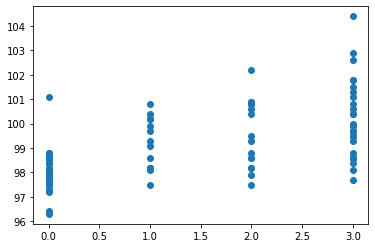

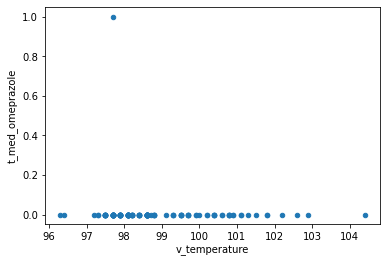

In [18]:
#plot the scatter plot of balance and salary variable in data
plt.scatter(df_final.s_odynophagia,df_final.v_temperature)
plt.show()

#plot the scatter plot of balance and age variable in data
df_final.plot.scatter(x="v_temperature",y="t_med_omeprazole")
plt.show()

## Additionally we ran a pair plot to show a correlation between the three variables

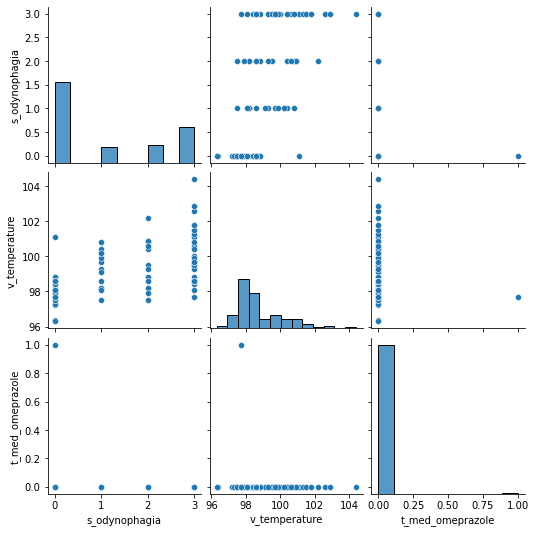

In [19]:
#plot the pair plot of salary, balance and age in data dataframe.
sns.pairplot(data = df_final, vars=['s_odynophagia','v_temperature','t_med_omeprazole'])
plt.show()